# IMPORTS

In [1]:
import pandas as pd
import numpy as np 

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold

import torch
from torch_geometric.nn import SchNet, NNConv, global_mean_pool, radius_graph
# from torch_geometric.loader import DataLoader
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.data import Data
from torch_cluster import radius_graph
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.functional import l1_loss
from collections import defaultdict

import itertools

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker

from collections import defaultdict

print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
print(torch.__version__)
print(torch.version.cuda)

CUDA available: True
CUDA device name: Tesla T4
2.1.2+cu121
12.1


# LOAD DATA

In [ ]:
# ####### Load expt and DFT data
# excel = "computed_VBur"
# bromides = "Sheet1"
# short_bromides = "Sheet2"#"test"

# bromide = pd.read_excel(excel+".xlsx",bromides,header=0, engine='openpyxl')
# short = pd.read_excel(excel+".xlsx",short_bromides,header=0, engine='openpyxl')

# bromide.insert(0, 'ID', 'bromide_' + bromide.index.astype(str))
# short.insert(0, 'ID', 'bromide_' + short.index.astype(str))

# display(bromide)

# clean_df = bromide[bromide["Steric"] > 40] 
# clean_df = clean_df.reset_index(drop=True)
# display(clean_df)

# SAVE SDFs

In [ ]:
# def save_conformer_as_sdf(mol, file_name, conformer_id=0):
#     writer = Chem.SDWriter(file_name)
#     writer.write(mol, confId=conformer_id)
#     writer.close()

# def get_LEC_and_save(smiles, molecule_id, output_dir, num_conformers=10):
#     mol = Chem.MolFromSmiles(smiles)
#     mol = Chem.AddHs(mol)
    
#     sorted_conformers = calculate_relative_energies(mol, num_conformers=num_conformers)
#     LEC_id = sorted_conformers[0][0]  # Assuming the first one is the LEC
#     LEC = get_coordinates(mol, LEC_id)

#     # Use the molecule ID as the file name
#     file_name = os.path.join(output_dir, f"{molecule_id}_LEC.sdf")
#     save_conformer_as_sdf(LEC, file_name, conformer_id=LEC_id)
    
#     return file_name

# # Specify the directory where you want to save the SDF files
# output_dir = "/uufs/chpc.utah.edu/common/home/u6048529/prediction/conformers/"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# dataframe = clean_df # Your existing DataFrame

# # Modify your workflow to save LEC conformers and store file paths
# dataframe['LEC_file_path'] = [get_LEC_and_save(smiles, molecule_id, output_dir) for smiles, molecule_id in zip(dataframe['smiles'], dataframe['ID'])]

# # Display the updated DataFrame
# display(dataframe)

In [ ]:
# dataframe.to_excel("sdf_dataframe.xlsx", index=False)

# LOAD SDF

In [2]:
excel = "../sdf_dataframe"
bromides = "Sheet1"

bromide = pd.read_excel(excel+".xlsx",bromides,header=0, engine='openpyxl')

clean_df = bromide[bromide["Steric"] > 40] 
clean_df = clean_df.reset_index(drop=True)
display(clean_df)
bromide_coppermap = pd.read_csv('bromide_coppermap.csv')

,ID,id_lucas,id_therese,smiles,C_Steric_lucas,C_Steric_therese,Steric,LEC,min,max,LEC_file_path
0,bromide_0,alle_1,arbr2085,Brc1nc2ccccc2[nH]1,54.71778,54.732343,54.717780,53.296799,53.296799,53.296799,/uufs/chpc.utah.edu/common/home/u6048529/predi...
1,bromide_1,alle_1000,arbr2054,Brc1cscn1,57.00999,57.022223,57.009990,55.830111,55.830111,55.830111,/uufs/chpc.utah.edu/common/home/u6048529/predi...
2,bromide_2,alle_114,arbr1507,Brc1cccc2ncccc12,64.53888,64.600610,64.538880,63.169144,63.169144,63.169144,/uufs/chpc.utah.edu/common/home/u6048529/predi...
3,bromide_3,alle_116,arbr4572,COc1ccc(Br)cc1F,60.66844,60.678345,60.668440,58.490962,58.490962,58.490962,/uufs/chpc.utah.edu/common/home/u6048529/predi...
4,bromide_4,alle_117,arbr1531,Brc1cccc2cccnc12,63.40966,63.484788,63.409660,62.319465,62.319465,62.319465,/uufs/chpc.utah.edu/common/home/u6048529/predi...
...,...,...,...,...,...,...,...,...,...,...,...
5694,bromide_5695,NaN,arbr794,Brc1ccc(-c2cccc3ccccc23)cc1,NaN,60.837915,60.805468,58.477567,58.477567,58.477567,/uufs/chpc.utah.edu/common/home/u6048529/predi...
5695,bromide_5696,NaN,arbr795,Brc1ccc(-c2cccc3c2oc2ccccc23)cc1,NaN,60.630591,60.598725,58.440295,58.440295,58.440295,/uufs/chpc.utah.edu/common/home/u6048529/predi...
5696,bromide_5697,NaN,arbr798,Brc1ccc(-c2ccccn2)cc1,NaN,60.662039,60.630085,58.429230,58.422242,58.429230,/uufs/chpc.utah.edu/common/home/u6048529/predi...
5697,bromide_5698,NaN,arbr799,CC(C)(C)OC(=O)n1cccc1-c1ccc(Br)cc1,NaN,60.796566,60.764236,58.705856,58.674408,58.705856,/uufs/chpc.utah.edu/common/home/u6048529/predi...


In [3]:
def load_molecule_from_sdf(sdf_path):
    """ Load a molecule from an SDF file. """
    suppl = Chem.SDMolSupplier(sdf_path)
    for mol in suppl:
        if mol is not None:
            return mol
    return None

clean_df = bromide
# Assuming your DataFrame is named 'dataframe' and has a column 'LEC_file_path' with SDF file paths
clean_df['LEC_mol'] = clean_df['LEC_file_path'].apply(load_molecule_from_sdf)

bromides_test = pd.merge(bromide_coppermap, clean_df, on='id_lucas', how='inner')
clean_df = clean_df[~clean_df['id_lucas'].isin(bromides_test['id_lucas'])]

# display(bromides_test)
display(clean_df)

,ID,id_lucas,id_therese,smiles,C_Steric_lucas,C_Steric_therese,Steric,LEC,min,max,LEC_file_path,LEC_mol
0,bromide_0,alle_1,arbr2085,Brc1nc2ccccc2[nH]1,54.71778,54.732343,54.717780,53.296799,53.296799,53.296799,/uufs/chpc.utah.edu/common/home/u6048529/predi...,<rdkit.Chem.rdchem.Mol object at 0x7fea8365ea40>
22,bromide_22,alle_28,arbr2114,Brc1ncccn1,55.62337,55.700242,55.623370,54.943161,54.943161,54.943161,/uufs/chpc.utah.edu/common/home/u6048529/predi...,<rdkit.Chem.rdchem.Mol object at 0x7fea8365f0d0>
23,bromide_23,alle_340,arbr4603,COc1ccc2nc(Br)sc2c1,57.84220,57.887626,57.842200,57.374557,57.355922,57.374557,/uufs/chpc.utah.edu/common/home/u6048529/predi...,<rdkit.Chem.rdchem.Mol object at 0x7fea8365f140>
26,bromide_26,alle_2001,NaN,FC(F)(F)c1ccc(OCc2ccccc2)cc1Br,67.52702,NaN,67.527020,67.146734,67.121692,67.155470,/uufs/chpc.utah.edu/common/home/u6048529/predi...,<rdkit.Chem.rdchem.Mol object at 0x7fea8365f290>
27,bromide_27,alle_2002,NaN,O=C1c2ccccc2-c2ccc(Br)c3cccc1c23,64.68156,NaN,64.681560,63.260576,63.260576,63.260576,/uufs/chpc.utah.edu/common/home/u6048529/predi...,<rdkit.Chem.rdchem.Mol object at 0x7fea8365f300>
...,...,...,...,...,...,...,...,...,...,...,...,...
5694,bromide_5695,NaN,arbr794,Brc1ccc(-c2cccc3ccccc23)cc1,NaN,60.837915,60.805468,58.477567,58.477567,58.477567,/uufs/chpc.utah.edu/common/home/u6048529/predi...,<rdkit.Chem.rdchem.Mol object at 0x7fea834df8b0>
5695,bromide_5696,NaN,arbr795,Brc1ccc(-c2cccc3c2oc2ccccc23)cc1,NaN,60.630591,60.598725,58.440295,58.440295,58.440295,/uufs/chpc.utah.edu/common/home/u6048529/predi...,<rdkit.Chem.rdchem.Mol object at 0x7fea834df920>
5696,bromide_5697,NaN,arbr798,Brc1ccc(-c2ccccn2)cc1,NaN,60.662039,60.630085,58.429230,58.422242,58.429230,/uufs/chpc.utah.edu/common/home/u6048529/predi...,<rdkit.Chem.rdchem.Mol object at 0x7fea834df990>
5697,bromide_5698,NaN,arbr799,CC(C)(C)OC(=O)n1cccc1-c1ccc(Br)cc1,NaN,60.796566,60.764236,58.705856,58.674408,58.705856,/uufs/chpc.utah.edu/common/home/u6048529/predi...,<rdkit.Chem.rdchem.Mol object at 0x7fea834dfa00>


# CONFORMER FINDING

In [ ]:
# def generate_conformers(mol, num_conformers=10):
#     conformer_ids = AllChem.EmbedMultipleConfs(mol, numConfs=num_conformers)
#     return list(conformer_ids)

# def calculate_energy(mol, conformer_id, minimize=False):
#     force_field = AllChem.UFFGetMoleculeForceField(mol, confId=conformer_id)
# #     force_field = AllChem.MMFFGetMoleculeForceField(molecule, AllChem.MMFFGetMoleculeProperties(molecule), confId=conformer_id)
#     force_field.Initialize()
#     if minimize:
#         force_field.Minimize()
#     energy = round(force_field.CalcEnergy(), 4)
#     return energy

# def get_coordinates(mol, conformer_id):
#     conformer = mol.GetConformer(conformer_id)
#     conformer = Chem.Mol(conformer.GetOwningMol())
#     return(conformer)

# def calculate_relative_energies(mol, num_conformers=10, minimize=True):
#     conformer_ids = generate_conformers(mol, num_conformers=num_conformers)
    
#     conformer_energies = {}
#     unique_energies = set()
#     lowest_energy = float('inf')

#     for conf_id in conformer_ids:
#         energy = calculate_energy(mol, conf_id, minimize=minimize)
#         if energy < lowest_energy:
#             lowest_energy = energy
#         if energy not in unique_energies:
#             unique_energies.add(energy)
#             conformer_energies[conf_id] = energy

#     for conf_id in conformer_energies:
#         conformer_energies[conf_id] -= lowest_energy

#     sorted_conformers = sorted(conformer_energies.items(), key=lambda x: x[1])
#     return sorted_conformers

# def get_LEC(smiles, num_confomers=10):
#     mol = Chem.MolFromSmiles(smiles)
#     mol = Chem.AddHs(mol)
    
#     sorted_conformers = calculate_relative_energies(mol, num_conformers=10)
#     LEC = get_coordinates(mol, 0)        
#     return LEC

# dataframe = clean_df  # Your existing DataFrame

# LEC_mols = [get_LEC(smiles) for smiles in dataframe['smiles']]
# dataframe['LEC_mol'] = LEC_mols
# display(dataframe)

In [ ]:
# dataframe = clean_df  # Your existing DataFrame

# LEC_mols = [get_LEC(smiles) for smiles in dataframe['smiles']]
# dataframe['LEC_mol'] = LEC_mols
# display(dataframe)

# # dataframe.to_excel("short_LEC.xlsx", index=False)

# PREPARING DATASET

In [4]:
def mol_to_graph_data(mol):
#     mol = get_LEC(smiles)
    # Atomic numbers, IsInRing, IsAromatic, and positions
    atomic_nums = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    is_in_ring = [1 if atom.IsInRing() else 0 for atom in mol.GetAtoms()]
    is_aromatic = [1 if atom.GetIsAromatic() else 0 for atom in mol.GetAtoms()]
    number_bonds = [atom.GetDegree() for atom in mol.GetAtoms()]
    
    # One-hot encoding for number of bonds
    max_bonds = 7  # Assuming a maximum of 6 bonds for any atom
    one_hot_bonds = [[1 if i == nb else 0 for i in range(max_bonds)] for nb in number_bonds]

    # Positions
    positions = [mol.GetConformer().GetAtomPosition(atom.GetIdx()) for atom in mol.GetAtoms()]

    # Combine features
    features = [[atomic_num] + [is_ring] + [is_arom] + bond_vec 
                for atomic_num, is_ring, is_arom, bond_vec in zip(atomic_nums, is_in_ring, is_aromatic, one_hot_bonds)]
    z = torch.tensor(features, dtype=torch.long)
    pos = torch.tensor(positions, dtype=torch.float).view(-1, 3)

    return z, pos

def smiles_to_graph_data(mol, target):
    z, pos = mol_to_graph_data(mol)
    graph_data = Data(z=z, pos=pos, y=torch.tensor([target], dtype=torch.float))
    return graph_data

# Example usage
dataframe = clean_df  # Your DataFrame
target_column = "Steric"  # Column name for the target
graph_data_list = [smiles_to_graph_data(mol, target) for mol, target in zip(dataframe['LEC_mol'], dataframe[target_column])]

In [ ]:
# import pickle

# # # Save graph_data_list to a file
# # with open('graph_data_list.pkl', 'wb') as f:
# #     pickle.dump(graph_data_list, f)
    
# # # Load graph_data_list from a file
# # with open('graph_data_list.pkl', 'rb') as f:
# #     graph_data_list = pickle.load(f)

# # Save graph_data_list with torch.save
# # torch.save(graph_data_list, 'graph_data_list.pt')
# # # Load graph_data_list with torch.load
# graph_data_list = torch.load('graph_data_list.pt')

In [ ]:
# display(graph_data_list)

# NN MODEL 

## EMBEDDING LAYER FOR ATOMS

In [5]:
class AtomEmbedding(nn.Module):
    def __init__(self, embedding_dims):
        super(AtomEmbedding, self).__init__()
        # Embedding layers for atomic number, IsInRing, and IsAromatic
        self.atomic_num_embedding = nn.Embedding(100, embedding_dims // 2)
        self.is_in_ring_embedding = nn.Embedding(2, embedding_dims // 4)
        self.is_aromatic_embedding = nn.Embedding(2, embedding_dims // 4)
        
    def forward(self, features):
        # Split features
        # features is expected to be of shape [num_atoms, 10]
        # where the first three are atomic number, is_in_ring, is_aromatic
        # and the last seven are the one-hot encoded bond vector
        atomic_nums = features[..., 0]
        is_in_ring = features[..., 1]
        is_aromatic = features[..., 2]
        one_hot_bond = features[..., 3:]

        # Embed atomic number, IsInRing, and IsAromatic
        atomic_num_embedded = self.atomic_num_embedding(atomic_nums)
        is_in_ring_embedded = self.is_in_ring_embedding(is_in_ring)
        is_aromatic_embedded = self.is_aromatic_embedding(is_aromatic)

        # Concatenate embeddings and one-hot bond vector
        return torch.cat(
            [atomic_num_embedded, is_in_ring_embedded, is_aromatic_embedded, one_hot_bond], 
            dim=-1
        )

## RBF FOR DISTANCES

In [6]:
class RBFExpansion(nn.Module):
    def __init__(self, num_rbfs, cutoff):
        super(RBFExpansion, self).__init__()
        self.register_buffer('centers', torch.linspace(0, cutoff, num_rbfs))
        self.register_buffer('widths', torch.ones(num_rbfs) * (cutoff / num_rbfs))

    def forward(self, distances):
        distances = distances.unsqueeze(-1)  # [num_edges, 1]
        rbf = torch.exp(-((distances - self.centers) ** 2) / (2 * self.widths ** 2))
        return rbf

## MODEL ARCHITECTURE

In [7]:
class SchNetModified(nn.Module):
    def __init__(self, embedding_dim, num_rbf, cutoff, num_filters, num_interactions):
        super(SchNetModified, self).__init__()
        self.cutoff = cutoff  # Define cutoff as an attribute
        self.atom_embedding = AtomEmbedding(embedding_dim)
        self.rbf_expansion = RBFExpansion(num_rbf, cutoff)

        # Calculate the total embedding dimension
        total_embedding_dim = (embedding_dim // 2) + (embedding_dim // 4) + (embedding_dim // 4) + 7

        # Adjust the Linear layer dimensions inside NNConv
        self.interactions = nn.ModuleList([
            NNConv(
                in_channels=total_embedding_dim, 
                out_channels=num_filters, 
                nn=nn.Linear(num_rbf, total_embedding_dim * num_filters),  # Adjust this
                aggr='mean'
            )
            for _ in range(num_interactions)
        ])

        # Adjust the output layer
        self.lin = nn.Linear(total_embedding_dim, 1)  # Adjust the input size based on your task
        self.dropout = nn.Dropout(p=0.3) # Example dropout; adjust p as needed

    def forward(self, features, pos, batch):
        # Embed atomic numbers and print shape
        node_features = self.atom_embedding(features)

        # Calculate pairwise distances and expand with RBF
        pairwise_distances = (pos.unsqueeze(1) - pos.unsqueeze(0)).norm(dim=-1)
        edge_features = self.rbf_expansion(pairwise_distances)

        # Compute edge_index based on distance cutoff
        edge_index = radius_graph(pos, r=self.cutoff, batch=batch)

        # Flatten the edge features for each edge
        row, col = edge_index
        edge_features = edge_features[row, col]
        edge_features = edge_features.view(-1, num_rbf)  # Flatten to [num_edges, num_rbf]
        
        for interaction in self.interactions:
            node_features = interaction(node_features, edge_index, edge_features)
            node_features = self.dropout(node_features)  # Apply dropout

        # Global pooling
        pooled = global_mean_pool(node_features, batch)

        # Output layer
        output = self.lin(pooled)
        return output.squeeze(-1)

# CROSS-VALIDATION

## BATCHING

In [8]:
# Split the dataset into a training/validation set and a test set
training_data, test_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)

batch_size = 32
# Initialize the test DataLoader
test_loader = GeoDataLoader(test_data, batch_size=batch_size, shuffle=False)

## TRAINING

In [9]:
def evaluate_model(data_loader, model, device):
    model.eval()
    total_abs_error = 0.0
    total_samples = 0

    with torch.no_grad():
        for data in data_loader:
            data.to(device)
            outputs = model(data.z, data.pos, data.batch)
            abs_error = l1_loss(outputs, data.y, reduction='sum')
            total_abs_error += abs_error.item()
            total_samples += data.y.size(0)

    return total_abs_error / total_samples

# # Evaluate the model on the training and validation sets
# mae_train = evaluate_model(training_loader, model, device)
# mae_val = evaluate_model(test_loader, model, device)

# print(f'MAE on Training Set: {mae_train:.2f}')
# print(f'MAE on Validation Set: {mae_val:.2f}')

In [10]:
# def train_one_epoch(epoch_index, tb_writer, training_loader):
def train_one_epoch(epoch_index, training_loader):

    running_loss = 0.
    last_loss = 0.
    batches_since_last_printout = 0.
    for i, data in enumerate(training_loader):
        data = data.to(device)
        optimizer.zero_grad()
            
        # Make predictions for this batch
        outputs = model(data.z, data.pos, data.batch)

        # Compute the loss and its gradients
        loss = loss_func(outputs, data.y)        
        loss.backward()

        # Adjust learning weights
        optimizer.step()
            
        # Gather data and report
        running_loss += loss.item()
        batches_since_last_printout += 1

        n_training_batches = len(training_loader)
        if i % 50 == 49 or i + 1 == n_training_batches:  # Check for every 50th batch or the last batch
            last_loss = running_loss / batches_since_last_printout  # Use the actual number of batches since the last printout
            running_loss = 0.
            batches_since_last_printout = 0  # Reset the counter

    return last_loss

### KFOLD

In [ ]:
def kfold_CV(i, total_combinations, training_data, n_folds, n_epochs, model, device, batch_size):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    train_mae_list = []
    val_mae_list = []

    for fold, (train_indices, val_indices) in enumerate(kf.split(training_data)):
        print(f' *Fold {fold + 1}/{n_folds}')
        best_vmae = 1_000_000.
        best_tmae = 0

        # Split the data into training and validation sets
        train_dataset = [training_data[i] for i in train_indices]
        val_dataset = [training_data[i] for i in val_indices]

        # Create data loaders for training and validation sets
        training_loader = GeoDataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        validation_loader = GeoDataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Train the model for the current fold
        for epoch in range(n_epochs):
            model.train(True)
            avg_loss = train_one_epoch(epoch, training_loader)

            # Evaluate the model on the training and validation sets
            mae_train = evaluate_model(training_loader, model, device)
            mae_val = evaluate_model(validation_loader, model, device)
            
            if epoch % 25 == 24:
                print(f'   EPOCH {epoch + 1}/{n_epochs}, Fold {fold + 1}/{n_folds}:, Combination {i}/{total_combinations}')
                print(f'   MAE train: {mae_train:.3f}; MAE validation {mae_val:.3f}')

            # Track best performance, and save the model's state
            if mae_val < best_vmae:
                best_vmae = mae_val
                best_tmae = mae_train

        print(f"  @Best MAE train: {best_tmae:.3f}, validation: {best_vmae:.3f}")

        # Save the best MAE for each fold
        train_mae_list.append(best_tmae)
        val_mae_list.append(best_vmae)

    # Calculate the average MAE across all folds
    avg_train_mae = np.mean(train_mae_list)
    avg_val_mae = np.mean(val_mae_list)

    return avg_train_mae, avg_val_mae

In [ ]:
# Define the filename for the output file
output_filename_all = "hyperparameters_mae_LEC.txt"

# # Write the header to the file
# with open(output_filename_all, "w") as file:
#     file.write("embedding_dim, num_rbf, cutoff, num_interactions, train_mae, test_mae\n")

########################################################
embedding_dims = [64] 
num_rbfs = [64] 
cutoffs = [5]
num_interactions_list = [5, 10, 15]

total_combinations = len(embedding_dims) * len(num_rbfs) * len(cutoffs) * len(num_interactions_list)
########################################################

# Iterate over all combinations
for i, (embedding_dim, num_rbf, cutoff, num_interactions) in enumerate(itertools.product(embedding_dims, num_rbfs, cutoffs, num_interactions_list), start=1):
    print('-' * 40)
    print(f'Combination {i} of {total_combinations}: embedding_dim={embedding_dim}, num_rbf={num_rbf}, cutoff={cutoff}, num_interactions={num_interactions}')

    # Initialize the model with the current hyperparameters
    total_embedding_dim = (embedding_dim // 2) + (embedding_dim // 4) + (embedding_dim // 4) + 7
    model = SchNetModified(embedding_dim, num_rbf, cutoff, total_embedding_dim, num_interactions)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    loss_func = torch.nn.L1Loss() #MAE
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    ##
    n_epochs = 100
    n_folds = 4
    avg_train_mae, avg_val_mae = kfold_CV(i, total_combinations, training_data, n_folds, n_epochs, model, device, batch_size)
    ##    
        
    ##
    with open(output_filename_all, "a") as file:
        file.write(f"{embedding_dim}, {num_rbf}, {cutoff}, {num_interactions}, {avg_train_mae:.3f}, {avg_val_mae:.3f}\n")  

# FINAL TRAINING

In [11]:
########################################################
embedding_dims = 32
num_rbfs = 64
cutoffs = 5
num_interactions = 10
########################################################
# Instantiate GCN model
total_embedding_dims = (embedding_dims // 2) + (embedding_dims // 4) + (embedding_dims // 4) + 7
model = SchNetModified(embedding_dims, num_rbfs, cutoffs, total_embedding_dims, num_interactions)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_func = torch.nn.L1Loss() #MAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

SchNetModified(
  (atom_embedding): AtomEmbedding(
    (atomic_num_embedding): Embedding(100, 16)
    (is_in_ring_embedding): Embedding(2, 8)
    (is_aromatic_embedding): Embedding(2, 8)
  )
  (rbf_expansion): RBFExpansion()
  (interactions): ModuleList(
    (0-9): 10 x NNConv(39, 39, aggr=mean, nn=Linear(in_features=64, out_features=1521, bias=True))
  )
  (lin): Linear(in_features=39, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [12]:
def evaluate_model_training(data_loader, model, device):
    model.eval()
    total_abs_error = 0.0
    total_samples = 0

    with torch.no_grad():
        for data in data_loader:
            data.to(device)
            outputs = model(data.z, data.pos, data.batch)
            abs_error = l1_loss(outputs, data.y, reduction='sum')
            total_abs_error += abs_error.item()
            total_samples += data.y.size(0)

    return total_abs_error / total_samples

# # Evaluate the model on the training and validation sets
# mae_train = evaluate_model(training_loader, model, device)
# mae_val = evaluate_model(test_loader, model, device)

# print(f'MAE on Training Set: {mae_train:.2f}')
# print(f'MAE on Validation Set: {mae_val:.2f}')

In [13]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

def train_one_epoch_final(epoch_index, training_loader):
    running_loss = 0.
    last_loss = 0.
    batches_since_last_printout = 0.
    for i, data in enumerate(training_loader):
        data = data.to(device)
        optimizer.zero_grad()
            
        # Make predictions for this batch
        outputs = model(data.z, data.pos, data.batch)

        # Compute the loss and its gradients
        loss = loss_func(outputs, data.y)        
        loss.backward()

        # Adjust learning weights
        optimizer.step()
            
        # Gather data and report
        running_loss += loss.item()
        batches_since_last_printout += 1
        
        n_training_batches = len(training_loader)
        if i % 50 == 49 or i + 1 == n_training_batches:  # Check for every 50th batch or the last batch
            last_loss = running_loss / batches_since_last_printout  # Use the actual number of batches since the last printout
            running_loss = 0.
            batches_since_last_printout = 0  # Reset the counter

    # Update the learning rate based on the average loss of the epoch
    scheduler.step(last_loss)

    return last_loss

In [ ]:
# output_filename_training = "3DGNN_LEC_training_FINALTRAINING.txt"

# # Write the header to the file
# with open(output_filename_training, "w") as file:
#     file.write("EPOCH, Adjusted MAE, MAE Train, MAE Test, Best MAE Test, epochs_since_improvement\n")

In [14]:
class SchNetModified(nn.Module):
    def __init__(self, embedding_dims, num_rbfs, cutoff, num_filters, num_interactions):
        super(SchNetModified, self).__init__()
        self.cutoff = cutoff  # Define cutoff as an attribute
        self.atom_embedding = AtomEmbedding(embedding_dims)
        self.rbf_expansion = RBFExpansion(num_rbfs, cutoff)

        # Calculate the total embedding dimension
        total_embedding_dims = (embedding_dims // 2) + (embedding_dims // 4) + (embedding_dims // 4) + 7

        # Adjust the Linear layer dimensions inside NNConv
        self.interactions = nn.ModuleList([
            NNConv(
                in_channels=total_embedding_dims, 
                out_channels=num_filters, 
                nn=nn.Linear(num_rbfs, total_embedding_dims * num_filters),  # Adjust this
                aggr='mean'
            )
            for _ in range(num_interactions)
        ])

        # Adjust the output layer
        self.lin = nn.Linear(total_embedding_dims, 1)  # Adjust the input size based on your task
        self.dropout = nn.Dropout(p=0.3) # Example dropout; adjust p as needed

    def forward(self, features, pos, batch):
        # Embed atomic numbers and print shape
        node_features = self.atom_embedding(features)

        # Calculate pairwise distances and expand with RBF
        pairwise_distances = (pos.unsqueeze(1) - pos.unsqueeze(0)).norm(dim=-1)
        edge_features = self.rbf_expansion(pairwise_distances)

        # Compute edge_index based on distance cutoff
        edge_index = radius_graph(pos, r=self.cutoff, batch=batch)

        # Flatten the edge features for each edge
        row, col = edge_index
        edge_features = edge_features[row, col]
        edge_features = edge_features.view(-1, num_rbfs)  # Flatten to [num_edges, num_rbf]
        
        for interaction in self.interactions:
            node_features = interaction(node_features, edge_index, edge_features)
            node_features = self.dropout(node_features)  # Apply dropout

        # Global pooling
        pooled = global_mean_pool(node_features, batch)

        # Output layer
        output = self.lin(pooled)
        return output.squeeze(-1)

In [ ]:
########################################################
embedding_dim = 32
num_rbf = 64
cutoff = 5
num_interactions = 10
total_embedding_dim = (embedding_dim // 2) + (embedding_dim // 4) + (embedding_dim // 4) + 7
n_epochs = 2000
########################################################
early_stop_patience = 2000
########################################################
# batch_size = 32
# Initialize the test DataLoader
# training_loader = GeoDataLoader(training_data, batch_size=batch_size, shuffle=True)
# test_loader = GeoDataLoader(test_data, batch_size=batch_size, shuffle=False)
train_data, val_data = train_test_split(training_data, test_size=0.2, random_state=42)
training_loader = GeoDataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = GeoDataLoader(val_data, batch_size=batch_size, shuffle=False)
########################################################
model = SchNetModified(embedding_dim, num_rbf, cutoff, total_embedding_dim, num_interactions)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_func = torch.nn.L1Loss() #MAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
########################################################
best_testmae = 1_000_000.
best_trainmae = 1_000_000.
best_adjusted_mae = 1_000_000.
epochs_since_improvement = 0
##
# overfit_penalty_factor = 0.75  # Adjust this factor to control the penalty strength
overfit_penalty_factor = 0.3  # Adjust this value as needed
relative_difference_threshold = 0.2  # Define a threshold for acceptable relative difference

for epoch in range(n_epochs):
    model.train(True)
    avg_loss = train_one_epoch_final(epoch, training_loader)

    # Evaluate the model on the training and validation sets
    mae_train = evaluate_model_training(training_loader, model, device)
    mae_test = evaluate_model_training(val_loader, model, device)
    
    overfit_penalty_factor = 0.3  # Adjust this value as needed
    relative_difference_threshold = 0.2  # Define a threshold for acceptable relative difference

    # Calculate the relative difference between test and train MAE
    relative_difference = (mae_test - mae_train) / mae_train

    # Apply a penalty if the relative difference exceeds the threshold
    if relative_difference > relative_difference_threshold:
        overfit_penalty = (relative_difference - relative_difference_threshold) * overfit_penalty_factor
    else:
        overfit_penalty = 0

    adjusted_mae = mae_train + overfit_penalty

    # Track best performance, and save the model's state
    if adjusted_mae < best_adjusted_mae:
        best_adjusted_mae = adjusted_mae
        best_testmae = mae_test
        best_trainmae = mae_train
        torch.save(model.state_dict(), 'best_model_3DGNN_LEC_FINALTRAINING.pth')  # Save the model state
        epochs_since_improvement = 0 
    else:
        epochs_since_improvement += 1

    if epoch % 2 == 1:
        print(f'   EPOCH {epoch + 1}/{n_epochs}')
        print(f'   Adjusted MAE: {adjusted_mae:.3f}; MAE train: {mae_train:.3f}; MAE test: {mae_test:.3f}; Epochs Since Improvement: {epochs_since_improvement}')

    if epochs_since_improvement >= early_stop_patience:
        print(f"No improvement in MAE for {early_stop_patience} epochs. Stopping training.")
        break
        
    with open(output_filename_training, "a") as file:
        file.write(f"EPOCH: {epoch}; Adjusted MAE: {adjusted_mae:.3f}; MAE Train: {mae_train:.3f}; MAE Test: {mae_test:.3f}; Best MAE Test: {best_testmae:.3f}; epochs_since_improvement: {epochs_since_improvement}\n")      

print(f"@Best MAE train: {best_testmae:.3f}")        

# METRICS

In [ ]:
print("done")

In [15]:
# Split the dataset into a training/validation set and a test set
training_data, test_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)

batch_size = 32
# Initialize the test DataLoader
test_loader = GeoDataLoader(test_data, batch_size=batch_size, shuffle=False)
training_loader = GeoDataLoader(training_data, batch_size=batch_size, shuffle=True)

In [16]:
from sklearn.metrics import r2_score
from collections import defaultdict

def evaluate_model(data_loader, model, device):
    model.eval()
    total_abs_error = 0.0
    predictions = []
    mol_ids = []
    true_values = []
    
    with torch.no_grad():
        for data in data_loader:
            data.to(device)
            outputs = model(data.z, data.pos, data.batch)
            abs_error = l1_loss(outputs, data.y, reduction='sum')
            total_abs_error += abs_error.item()
            
            predictions.extend(outputs.cpu().numpy())
            true_values.extend(data.y.cpu().numpy())
            
    r2 = r2_score(true_values, predictions)
    
    return total_abs_error / len(true_values), r2

# # Evaluate the model on the training and validation sets
# mae_train, r2_train = evaluate_model(training_loader, model, device)
# mae_test, r2_test = evaluate_model(test_loader, model, device)

# print(f'MAE on Training Set: {mae_train:.2f}')
# print(f'R2 Training Set: {r2_train:.2f}')
# print(f'MAE on Validation Set: {mae_test:.2f}')

In [17]:
########################################################
embedding_dims = 32
num_rbfs = 64
cutoff = 5
num_interactions = 10
total_embedding_dims = (embedding_dims // 2) + (embedding_dims // 4) + (embedding_dims // 4) + 7
n_epochs = 2000
#####
model = SchNetModified(embedding_dims, num_rbfs, cutoff, total_embedding_dims, num_interactions)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# loss_func = torch.nn.L1Loss() #MAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load the saved state dictionary
model.load_state_dict(torch.load('best_model_3DGNN_LEC_FINALTRAINING.pth'))
# torch.save(model.state_dict(), 'best_model_256_20_2DGNN.pth')

# Set the model to evaluation mode
model.eval()

# Evaluate the model on the training and validation sets
mae_train, r2_train = evaluate_model(training_loader, model, device)
mae_test, r2_test = evaluate_model(test_loader, model, device)

print(f'MAE on Training Set: {mae_train:.3f}')
print(f'R2 Training Set: {r2_train:.2f}')
print(f'MAE on Test Set: {mae_test:.3f}')
print(f'R2 Test Set: {r2_test:.2f}')

# MAE on Training Set: 0.33
# R2 Training Set: 0.96
# MAE on Validation Set: 0.45
# R2 Validation Set: 0.93

MAE on Training Set: 0.314
R2 Training Set: 0.98
MAE on Test Set: 0.460
R2 Test Set: 0.93


In [18]:
def make_predictions(data_loader, model, device):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            outputs = model(data.z, data.pos, data.batch)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(data.y.cpu().numpy())
    
    return actuals, predictions

train_actuals, train_predictions = make_predictions(training_loader, model, device)
test_actuals, test_predictions = make_predictions(test_loader, model, device)

MAE on Training Set: 0.314
R2 Training Set: 0.98
MAE on Validation Set: 0.460
R2 Validation Set: 0.93


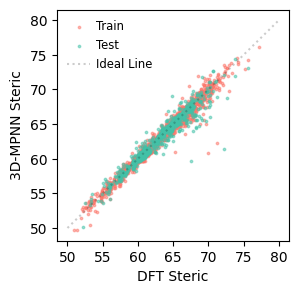

In [19]:
# Assuming min_y and max_y are set to the desired range
min_y = 50
max_y = 80

# Generate the ticks for both x and y axes
ticks = np.arange(min_y, max_y + 1, 5)

# Plot the predicted vs. actual values
print(f'MAE on Training Set: {mae_train:.3f}')
print(f'R2 Training Set: {r2_train:.2f}')
print(f'MAE on Validation Set: {mae_test:.3f}')
print(f'R2 Validation Set: {r2_test:.2f}')

plt.figure(figsize=(3, 3))

plt.scatter(train_actuals, train_predictions, marker='o', s=3, color='#FC766AFF', label='Train', alpha=0.5)
plt.scatter(test_actuals, test_predictions, marker='o', s=3, color='#42C2A8', label='Test', alpha=0.5)
plt.plot([min_y, max_y], [min_y, max_y], color='black', alpha=0.2, linestyle=':', label='Ideal Line')

plt.xlabel("DFT Steric")
plt.ylabel("3D-MPNN Steric")
plt.yticks(ticks)
plt.xticks(ticks)

plt.legend(fontsize='small', frameon=False, handletextpad=0.5)
# plt.legend(loc='upper left', fontsize='small', frameon=False, handletextpad=0.5)
# plt.savefig('MPNN_128x128_200.png', dpi=600, bbox_inches='tight')
plt.show()

# FINAL TEST

In [20]:
# display(bromides_test)

In [22]:
# Example usage
dataframe = bromides_test  # Your DataFrame
target_column = "Steric"  # Column name for the target
graph_data_list_test = [smiles_to_graph_data(mol, target) for mol, target in zip(dataframe['LEC_mol'], dataframe[target_column])]
# display(graph_data_list_test)

In [23]:
batch_size = 32
test_final_loader = GeoDataLoader(graph_data_list_test, batch_size=batch_size, shuffle=False)

mae, r2 = evaluate_model(test_final_loader, model, device)

print(f'MAE on Training Set: {mae:.3f}')
print(f'R2 Training Set: {r2:.2f}')

test_final_actuals, test_final_predictions = make_predictions(test_final_loader, model, device)

MAE on Training Set: 0.344
R2 Training Set: 0.98


MAE on Training Set: 0.344
R2 Training Set: 0.98


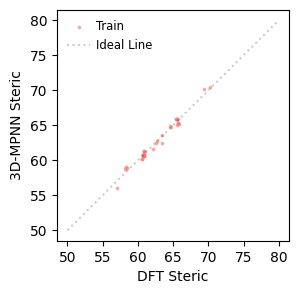

In [25]:
# Assuming min_y and max_y are set to the desired range
min_y = 50
max_y = 80

# Generate the ticks for both x and y axes
ticks = np.arange(min_y, max_y + 1, 5)

print(f'MAE on Training Set: {mae:.3f}')
print(f'R2 Training Set: {r2:.2f}')

plt.figure(figsize=(3, 3))

plt.scatter(test_final_actuals, test_final_predictions, marker='o', s=3, color='#FC766AFF', label='Train', alpha=0.5)
plt.plot([min_y, max_y], [min_y, max_y], color='black', alpha=0.2, linestyle=':', label='Ideal Line')

plt.xlabel("DFT Steric")
plt.ylabel("3D-MPNN Steric")
plt.yticks(ticks)
plt.xticks(ticks)

plt.legend(fontsize='small', frameon=False, handletextpad=0.5)
# plt.legend(loc='upper left', fontsize='small', frameon=False, handletextpad=0.5)
# plt.savefig('MPNN_128x128_200.png', dpi=600, bbox_inches='tight')
plt.show()

# ANALYZE ERRORS